In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import re
import copy

%cd ..
from utils import *

/scratch2/jsalle/ObsScaling


In [1]:
%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [3]:
base_llm_benchmark_eval = load_base_llm_benchmark_eval()
eval_result_path = "./eval_results/base_llm_post_training_eval.csv"
post_training_eval = pd.read_csv(eval_result_path)

# Merge 
base_llm_eval_with_post_training = pd.merge(base_llm_benchmark_eval, post_training_eval, on="Model")

mmlu_df = load_acc_mmlu_subtasks()
merged_eval = merge_mmlu_sutasks_with_init_df(base_llm_eval_with_post_training, mmlu_df)

/scratch2/jsalle/ObsScaling/utils/plot.py:786: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(figsize, 0.75 * len(x_metrics_list)))


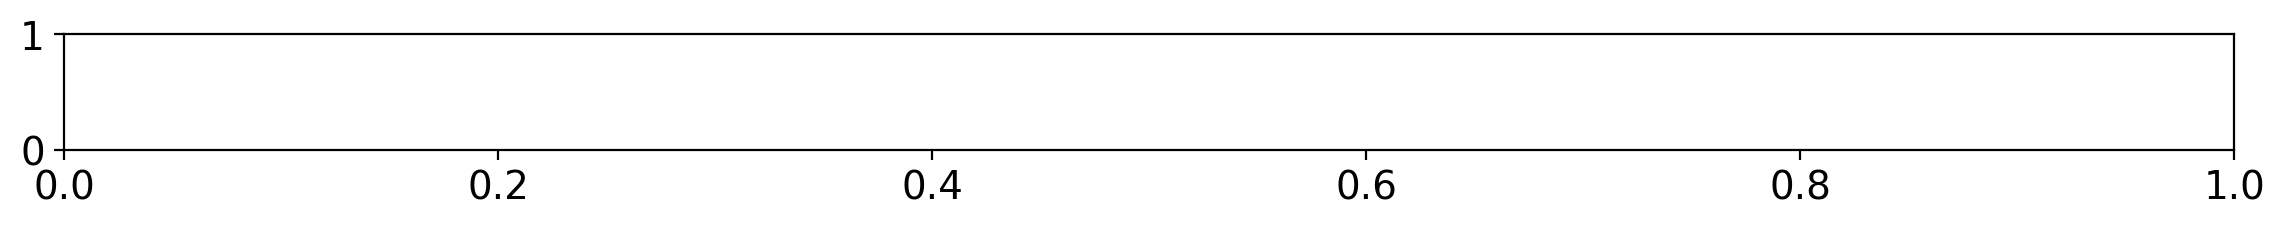

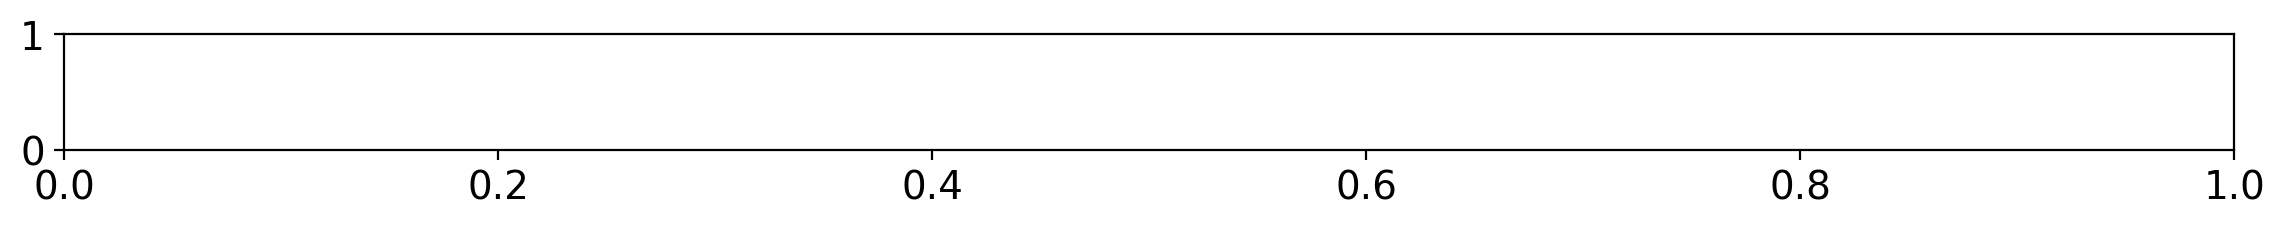

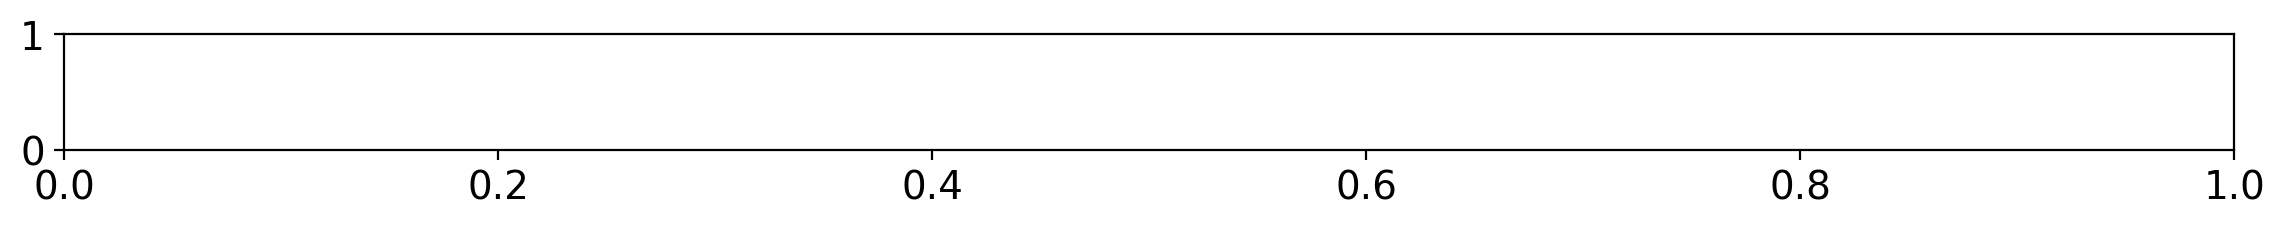

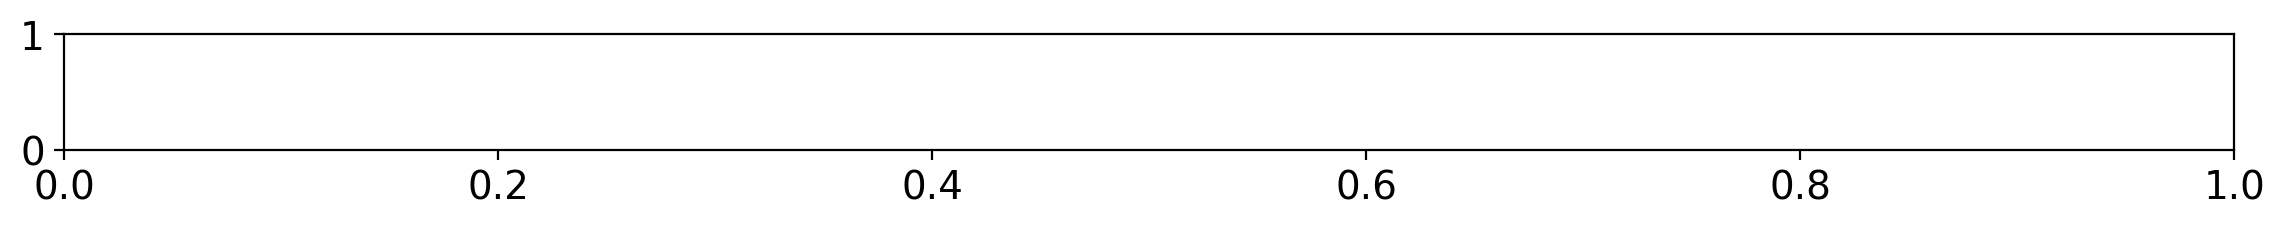

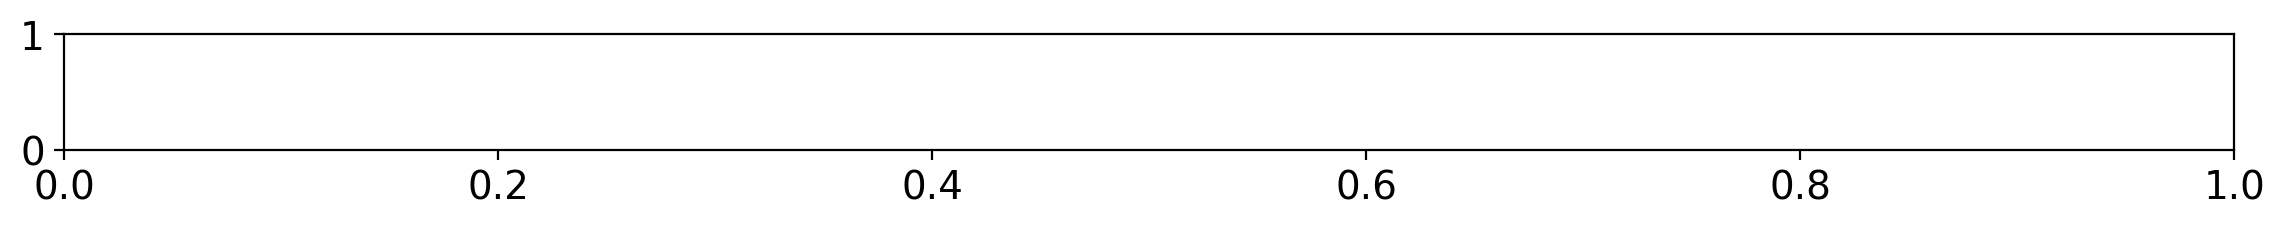

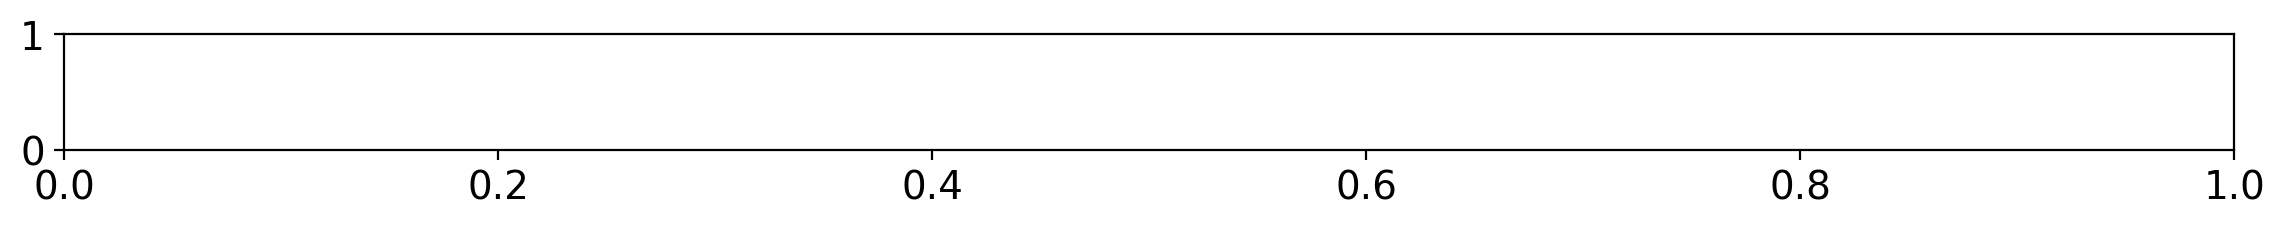

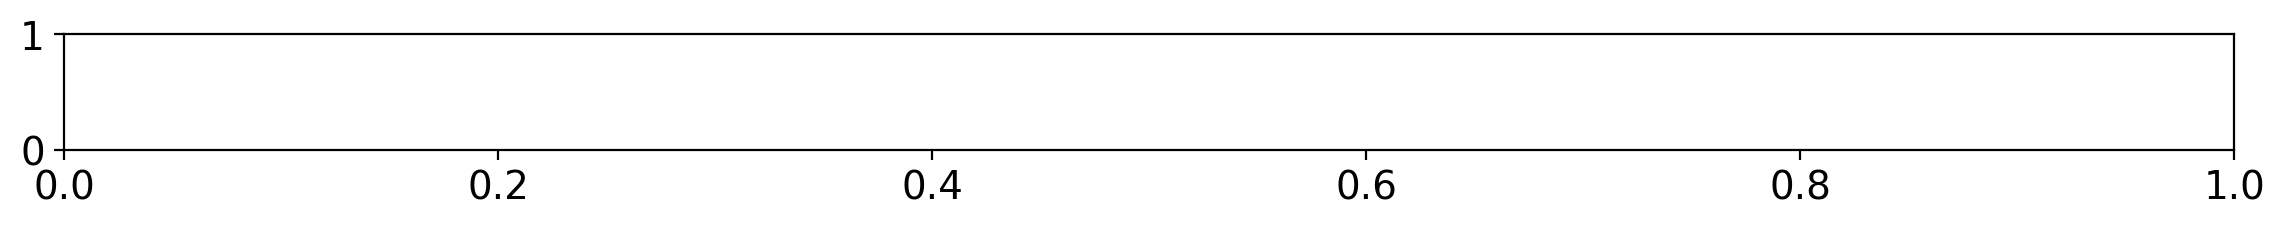

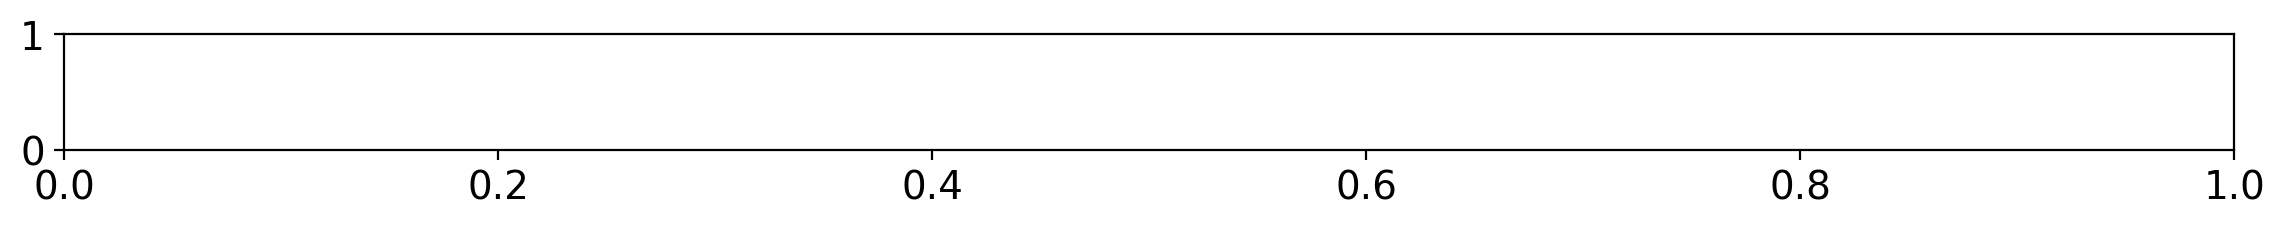

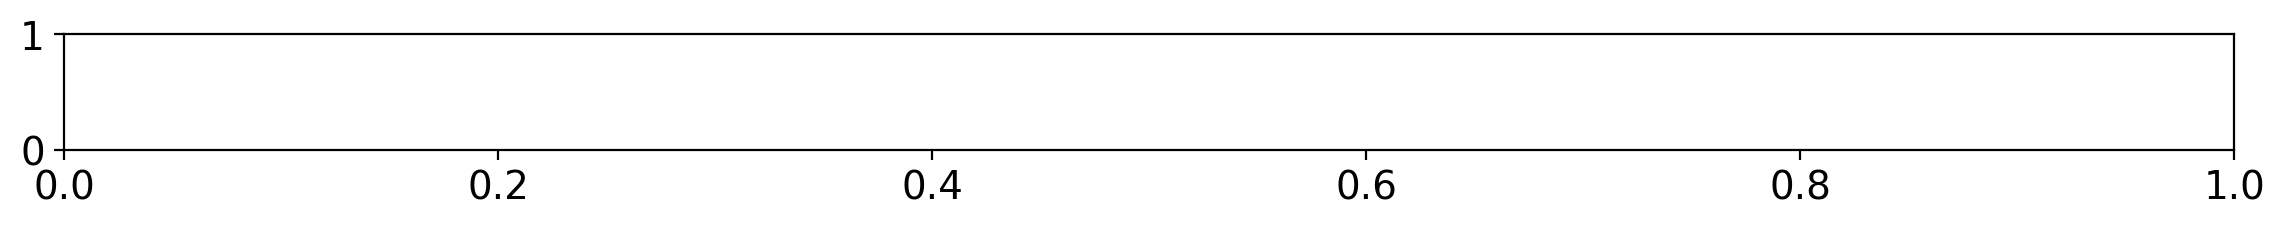

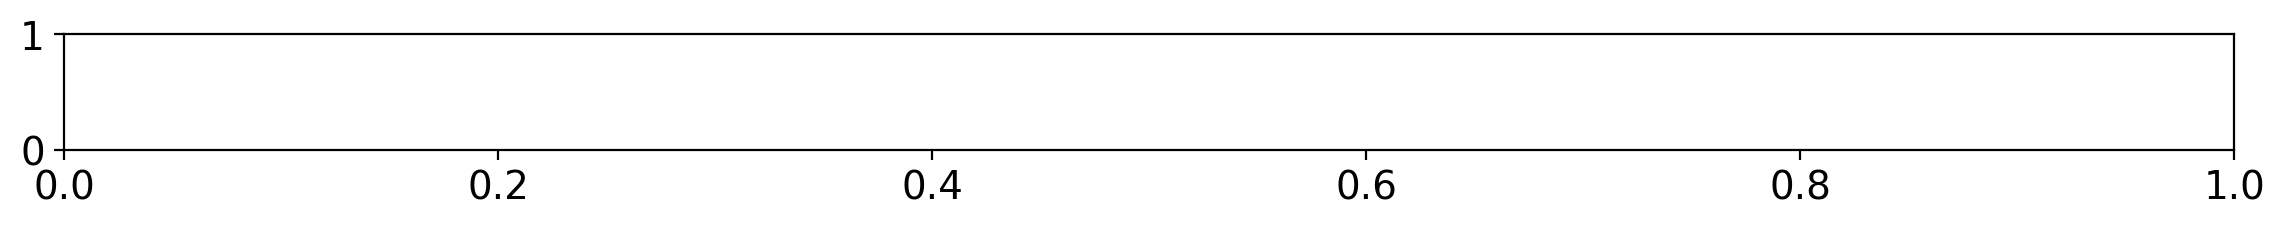

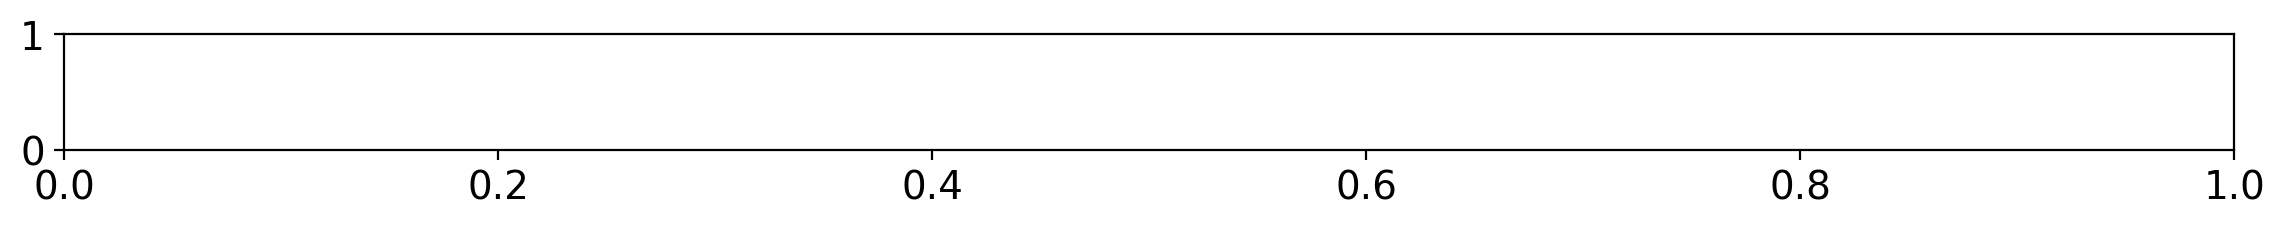

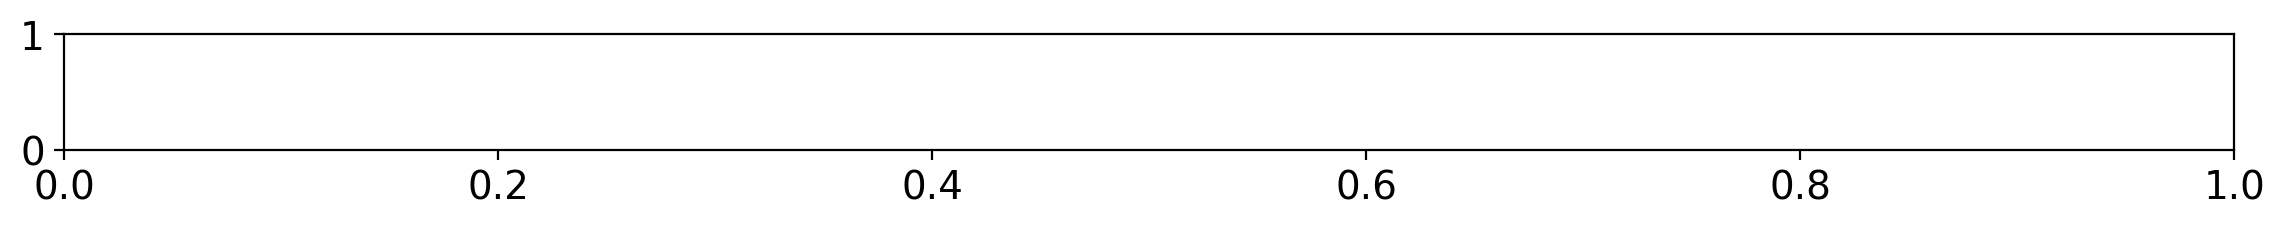

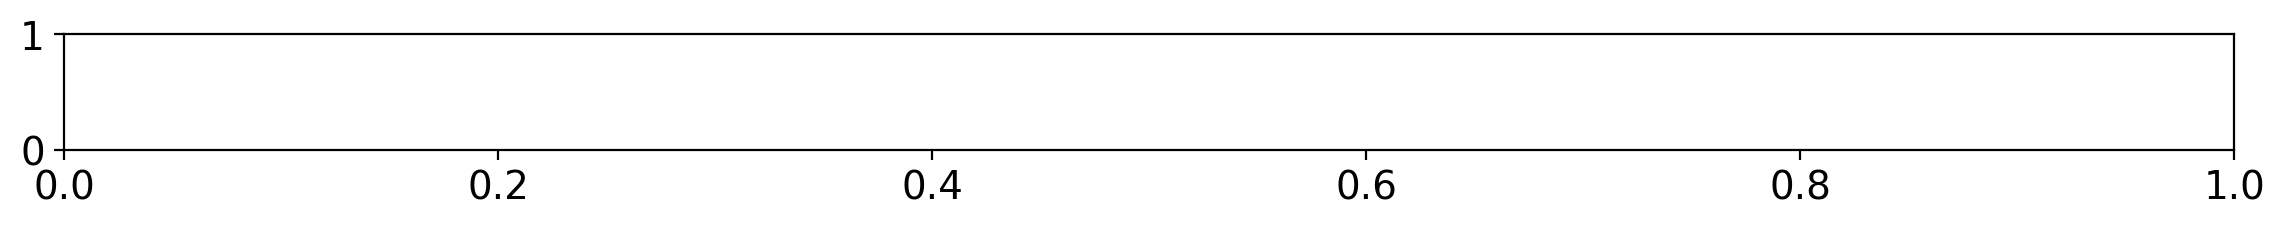

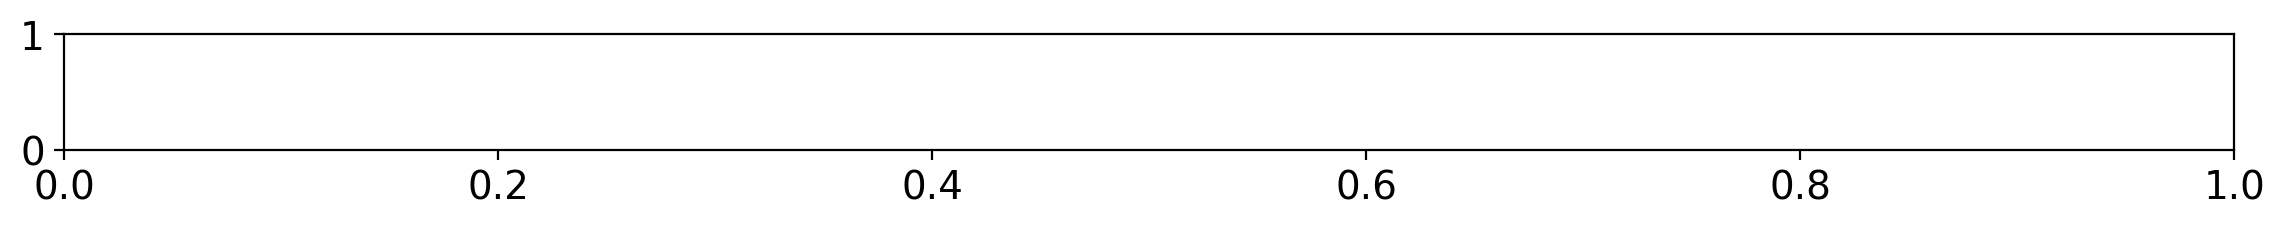

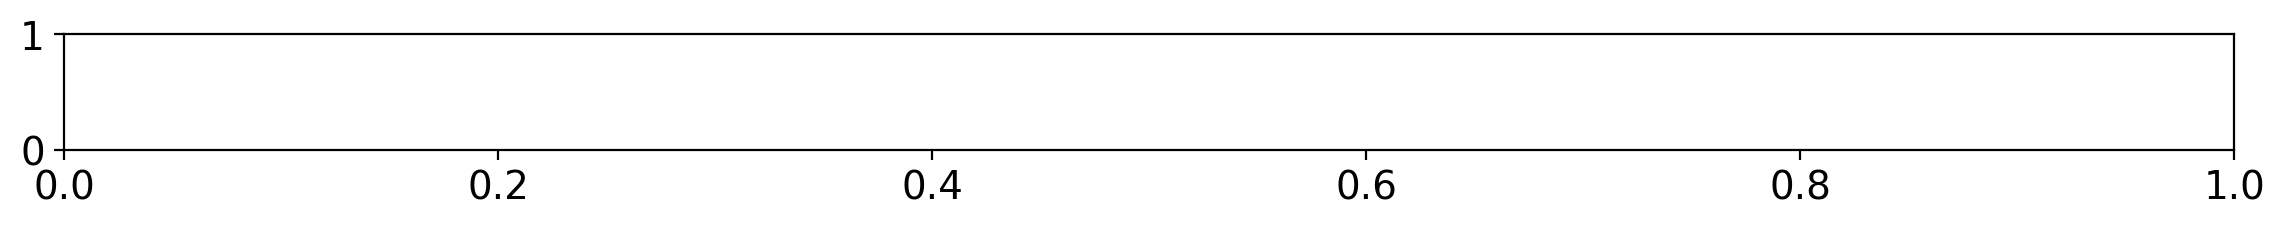

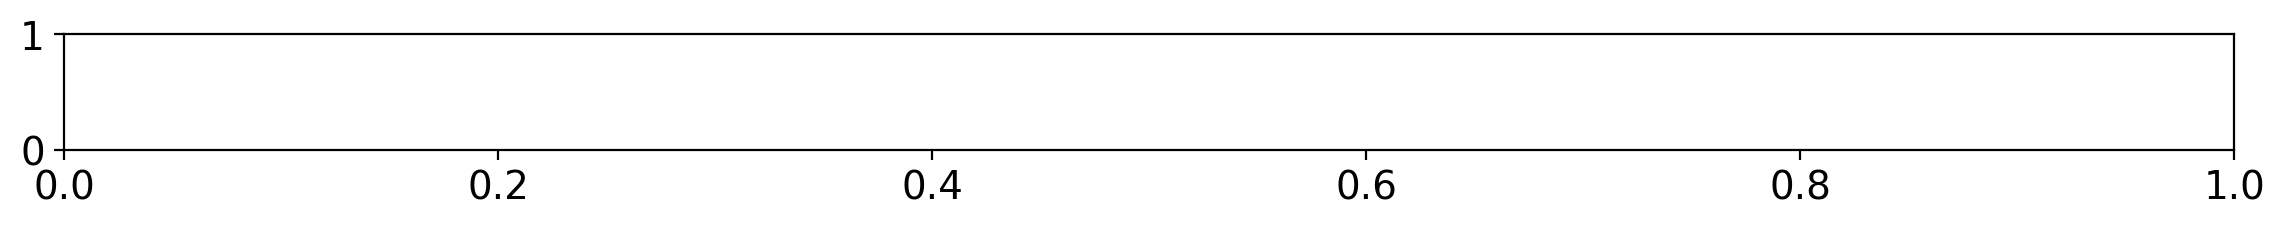

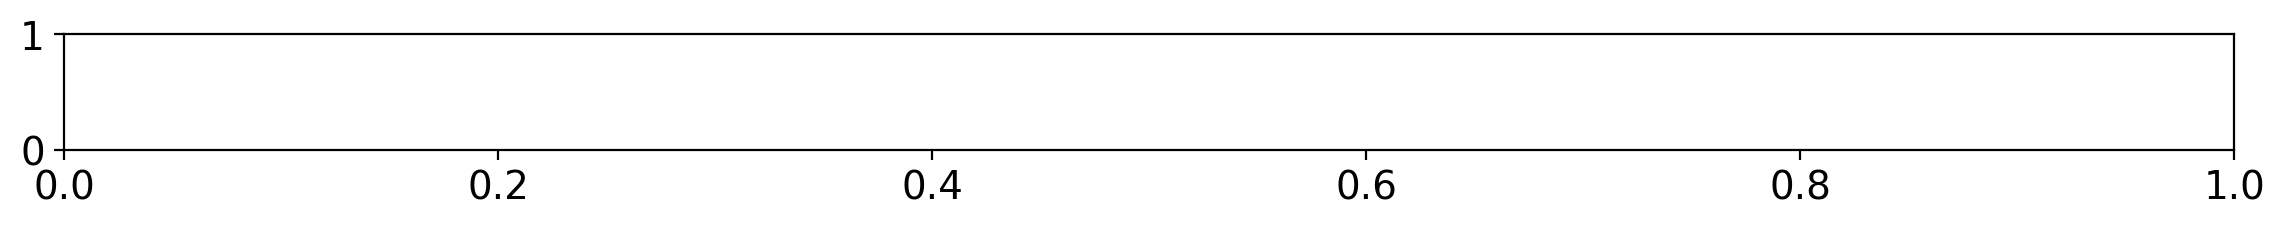

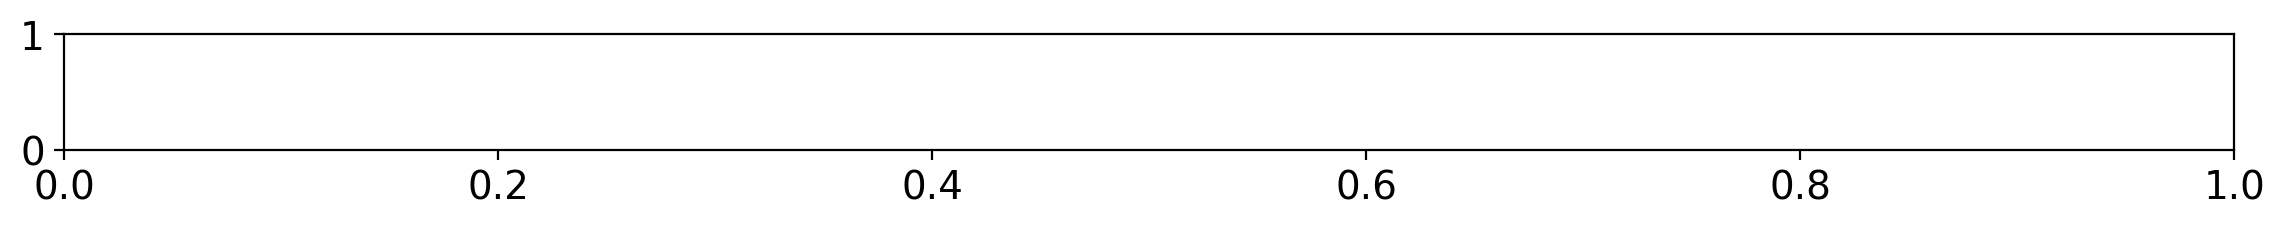

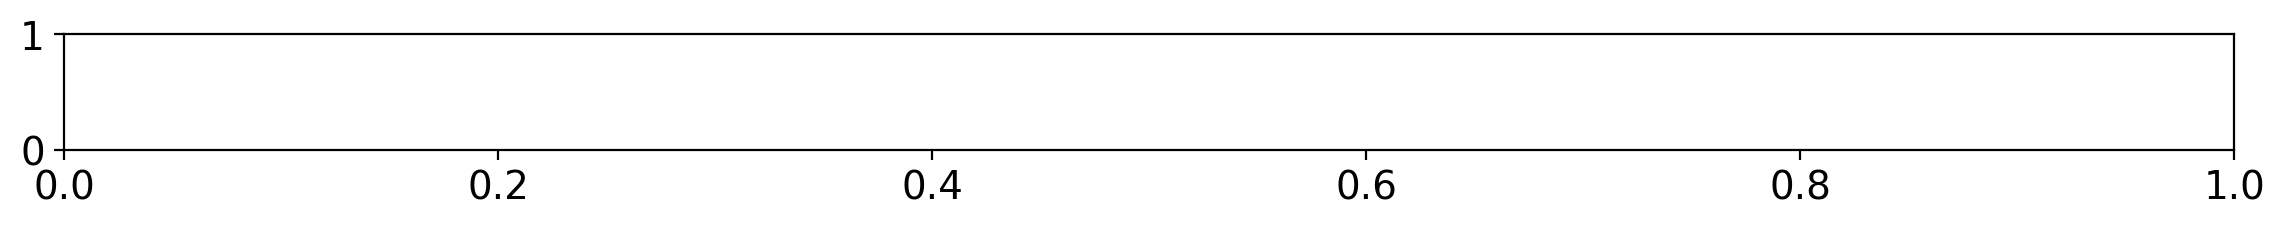

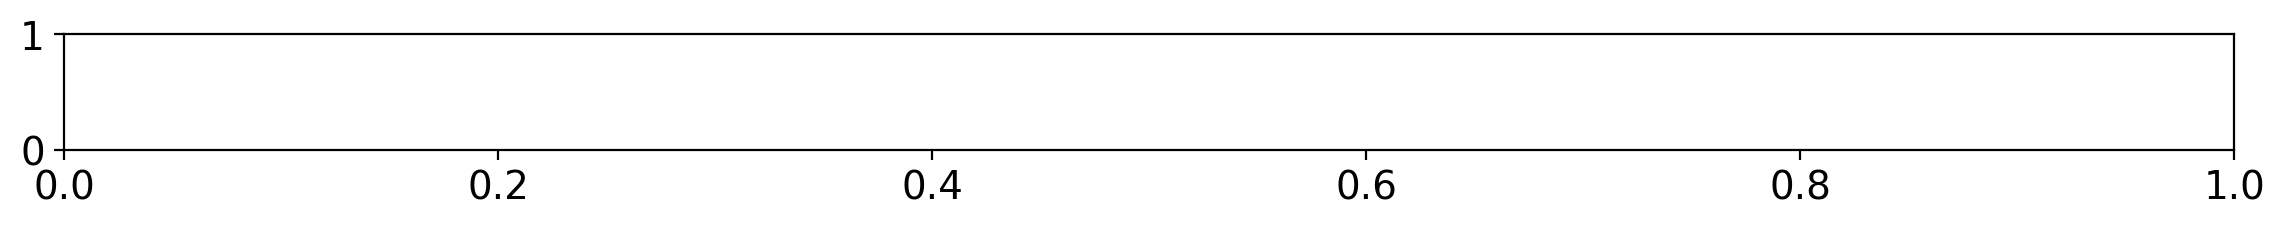

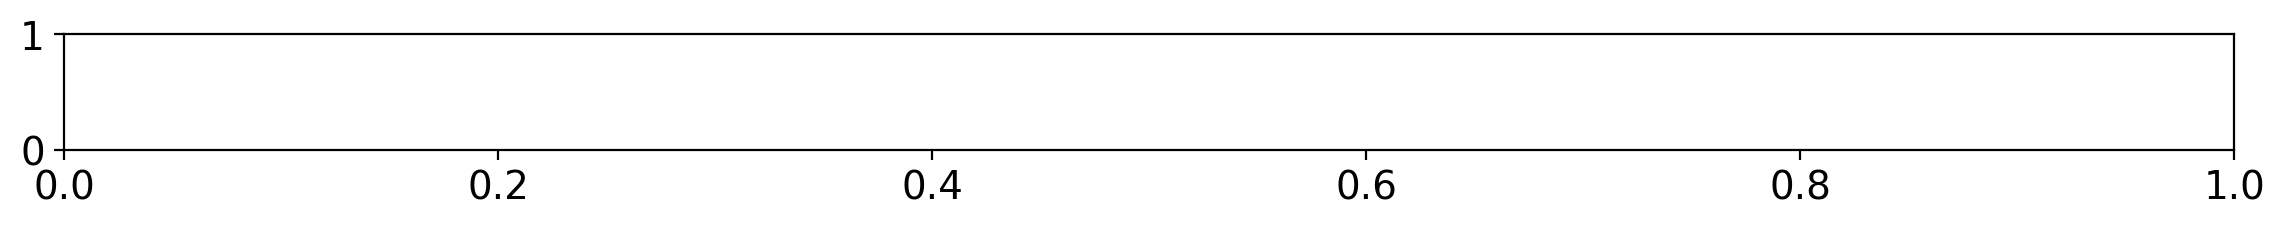

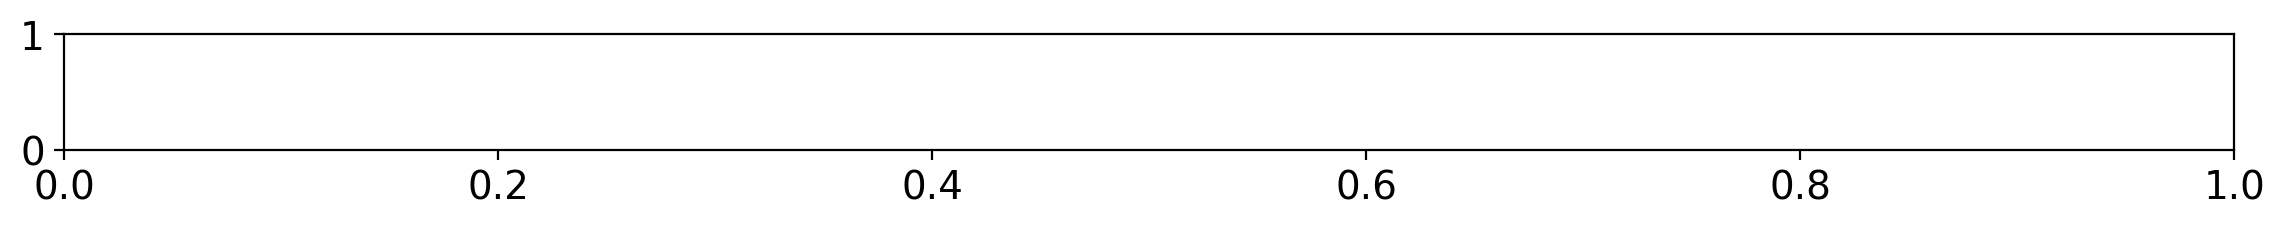

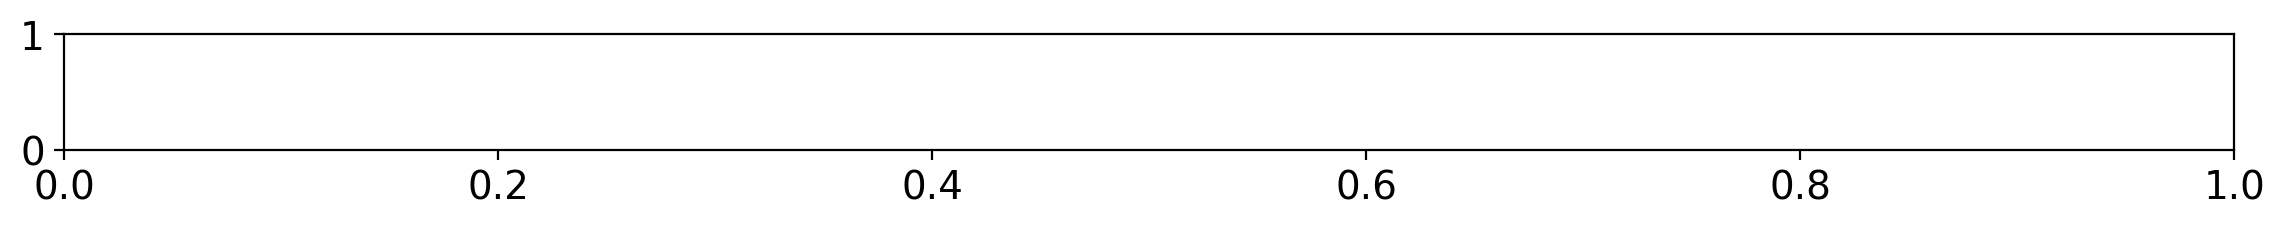

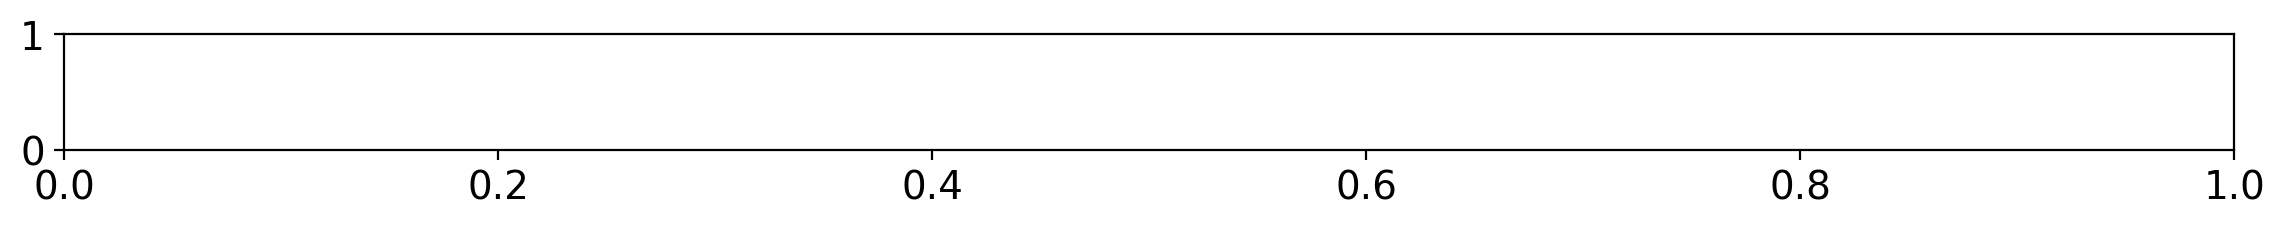

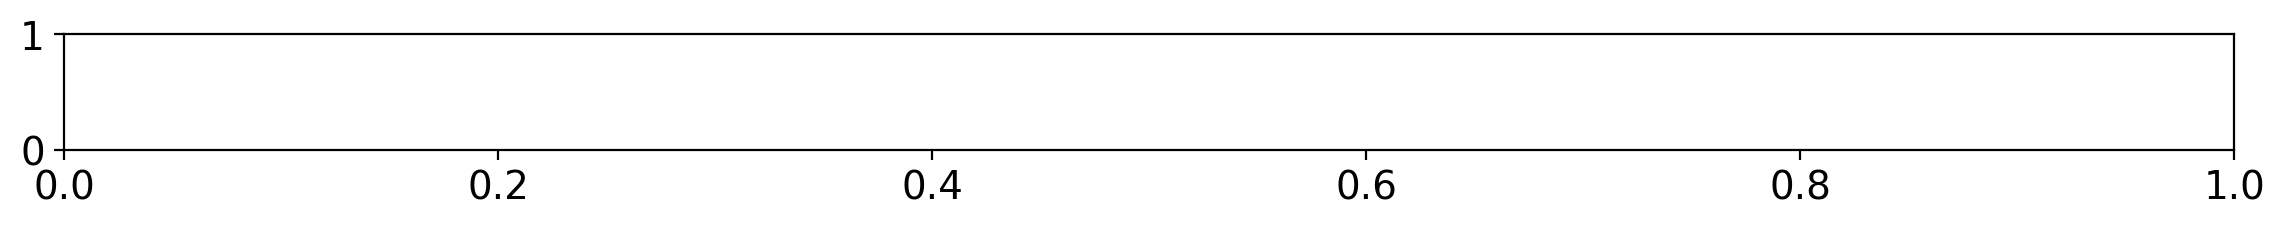

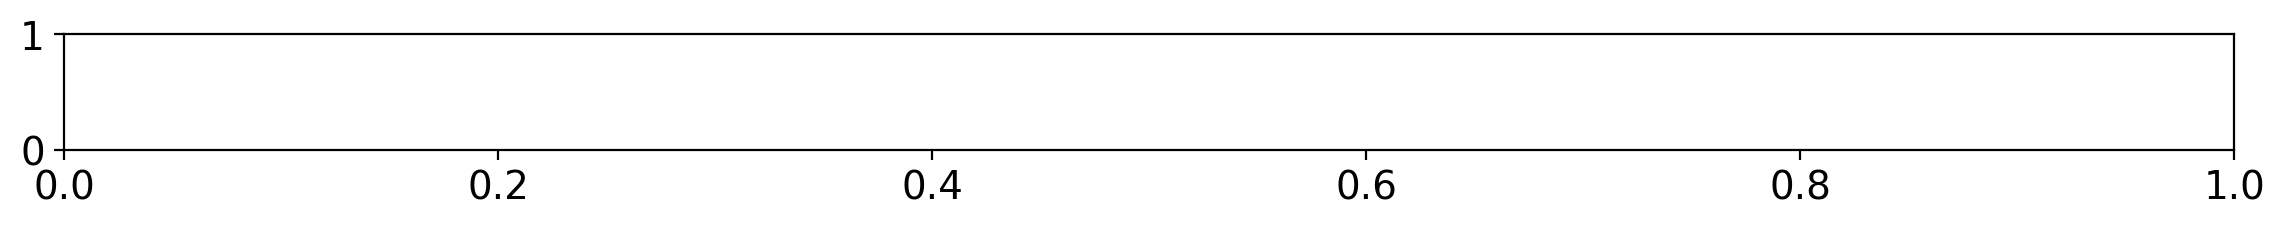

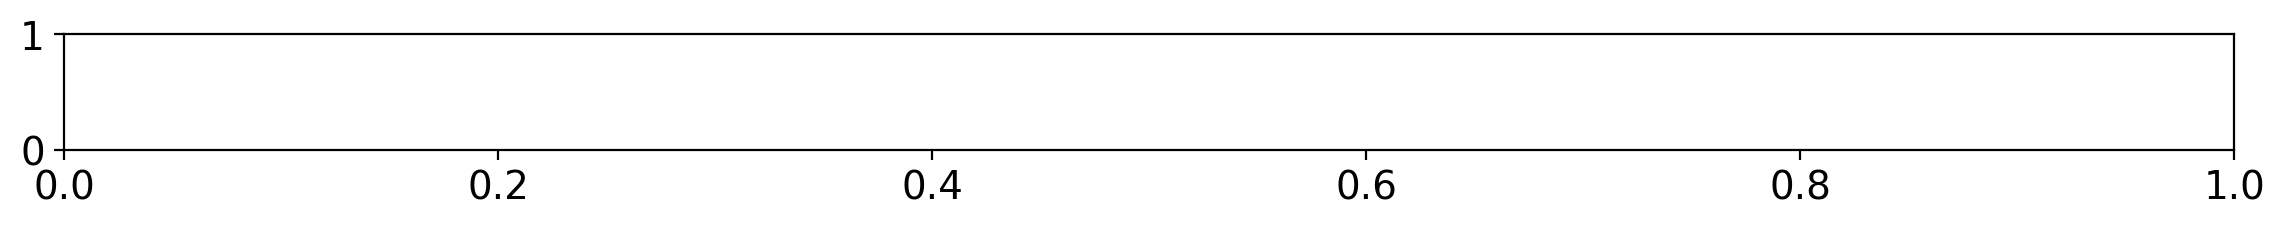

In [14]:
mmlu_df = load_acc_mmlu_subtasks()
mmlu_subtasks = [t for t in mmlu_df.columns if t != 'Model']

weights_ranks = pd.DataFrame()

for task in BBH_SUBTASKS:

    scaling1, analysis_setup, setup_specific_kwargs, orig_metric_map, color_map = get_bbh_subtask_scaling_metrics(task=task,
                                                                                                                  mmlu_subtasks=mmlu_subtasks)

    tiled_weights = plot_weight_analysis(
        merged_eval, 
        y_metrics=scaling1, 
        x_metrics_list=[PC_METRIC_NUM_2], 
        analysis_setup_kwargs=analysis_setup, 
        y_metric_specific_kwargs=setup_specific_kwargs, 
        #filter_model_family=EVAL_BASE_MODEL_FAMILIES, # not default
        norm_weights=False,
        remove_y_ticks=False,
        figsize=14,
        rotationx=90,
        cmap='coolwarm',
        v=2,
        task=task,
        get_tiled_weights=True
    )

    weights_ranks_list = [sorted(tiled_weights[0], reverse=True).index(x) for x in tiled_weights[0]]

    for i, bench in enumerate(analysis_setup['imputation_metrics']):

        temp_dict = {
            'task': task,
            'benchmark': bench,
            'rank': weights_ranks_list[i]
        }
        temp_df = pd.DataFrame(temp_dict, index=[0])
        
        weights_ranks = pd.concat([weights_ranks, temp_df], axis=0, ignore_index=True)

Text(0.5, 1.0, 'Mean rank for BBH on all BBH subtasks')

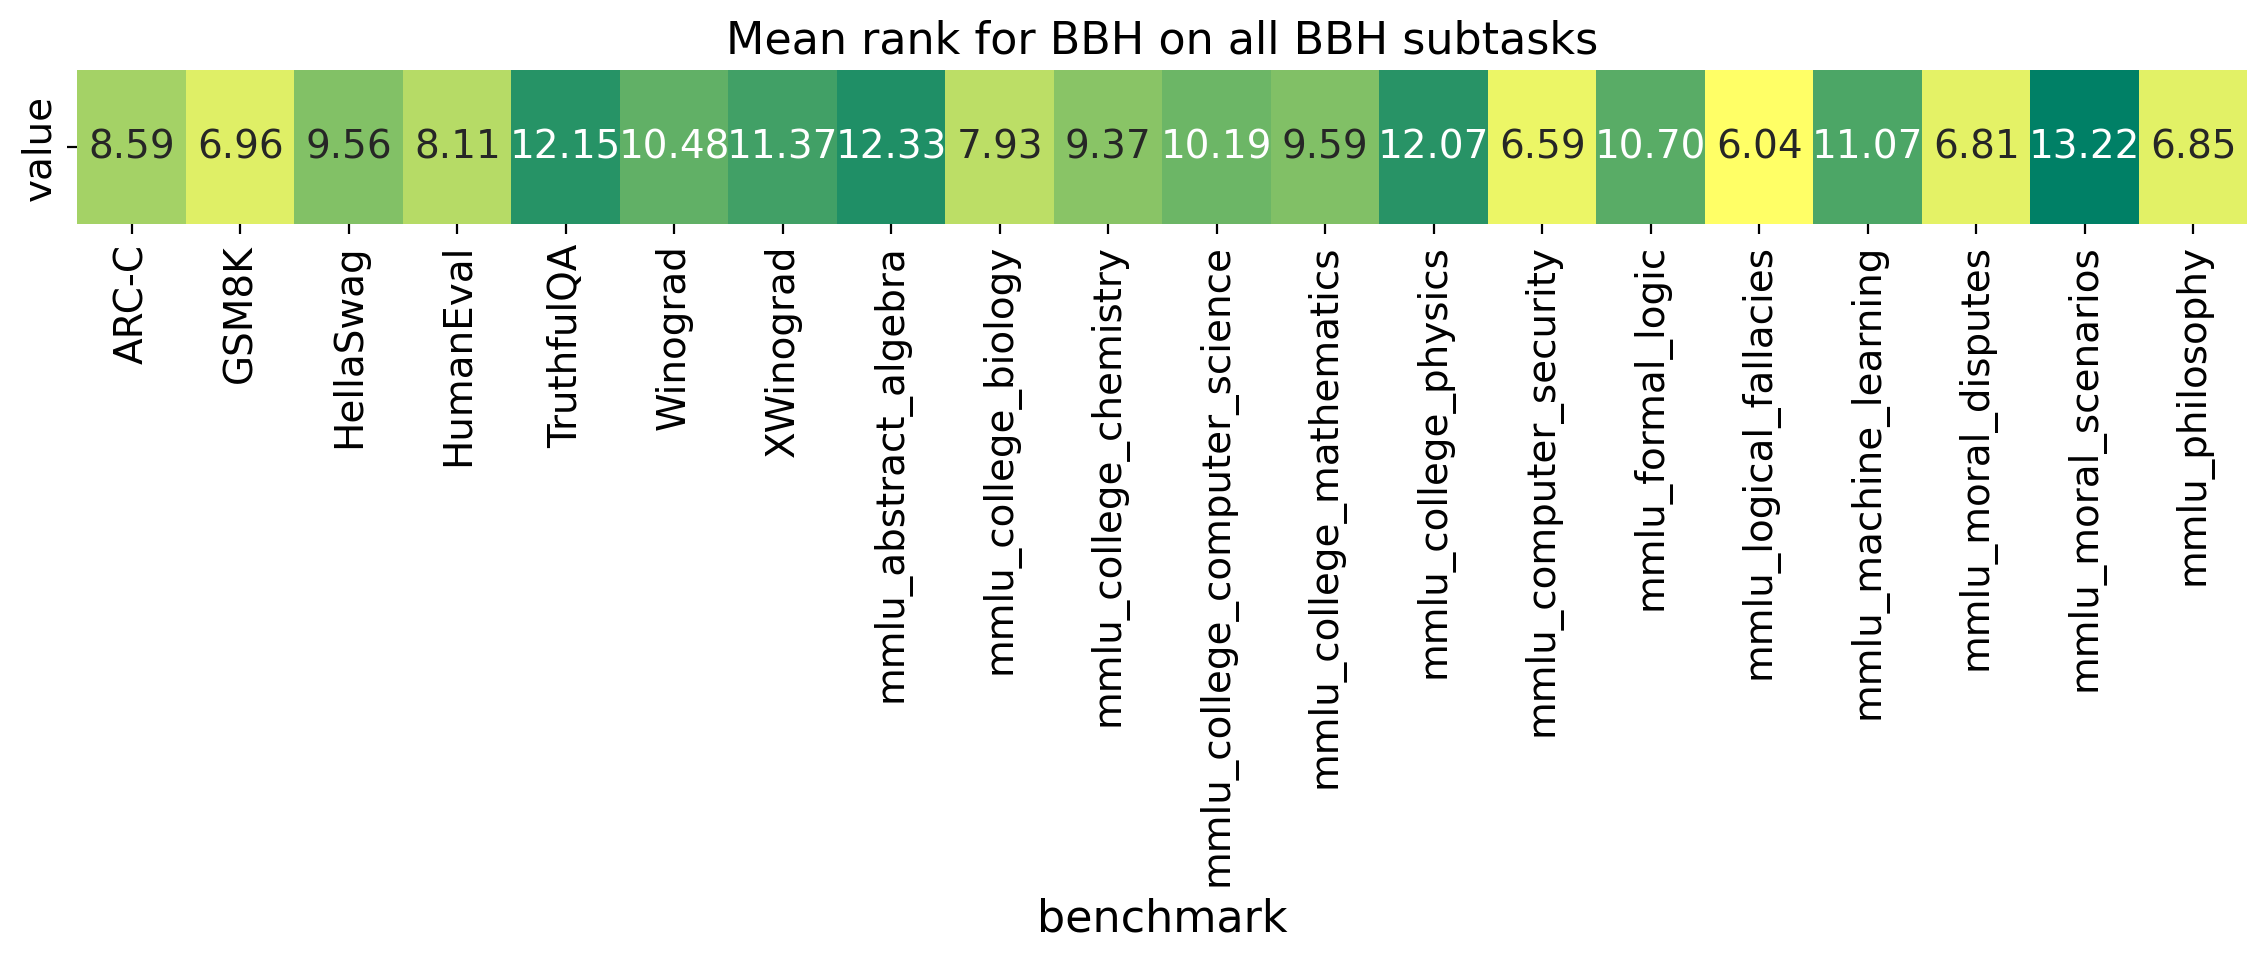

In [42]:
mean_ranks = weights_ranks.groupby(['benchmark'])['rank'].mean()

plt.figure(figsize=(14, 1))
sns.heatmap(mean_ranks.to_frame(name='value').T, cmap='summer_r', annot=True, fmt=".2f", cbar=False)
plt.title('Mean rank for BBH on all BBH subtasks')

Text(0.5, 1.0, 'Mean rank for BBH on all selected subtasks')

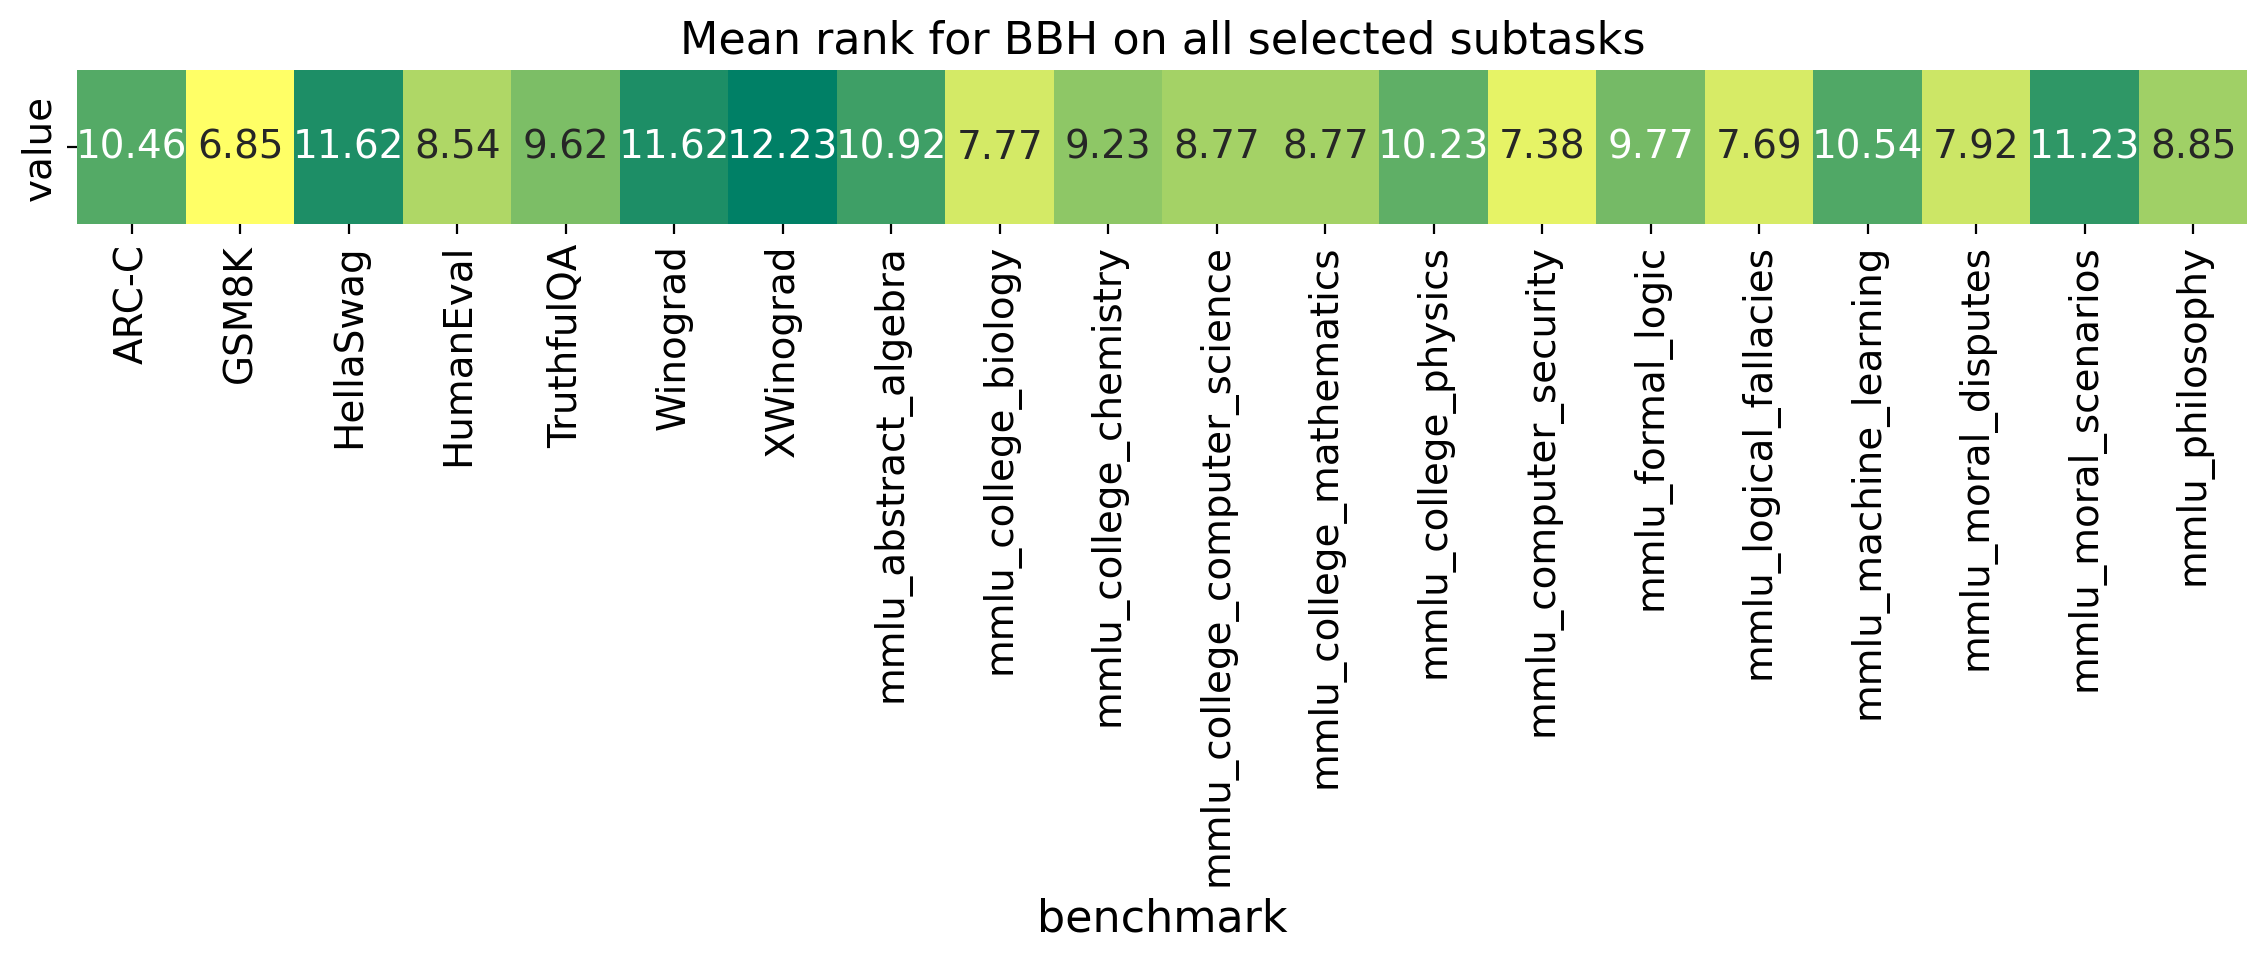

In [44]:
# I select BBH subtasks that show on improvement using CoT

selected_subtasks = [
    'date_understanding',
    'formal_fallacies',
    'logical_deduction_seven_objects',
    'logical_deduction_three_objects',
    'movie_recommendation',
    'multistep_arithmetic_two',
    'navigate',
    'object_counting',
    'penguins_in_a_table',
    'reasoning_about_colored_objects',
    'ruin_names',
    'sports_understanding',
    'temporal_sequences',
    'tracking_shuffled_objects_five_objects',
    'tracking_shuffled_objects_seven_objects',
    'tracking_shuffled_objects_three_objects',
    'web_of_lies',
]

weights_ranks = weights_ranks[weights_ranks['task'].isin(selected_subtasks)]
mean_ranks = weights_ranks.groupby(['benchmark'])['rank'].mean()

plt.figure(figsize=(14, 1))
sns.heatmap(mean_ranks.to_frame(name='value').T, cmap='summer_r', annot=True, fmt=".2f", cbar=False)
plt.title('Mean rank for BBH on all selected subtasks')

### BBH Overall

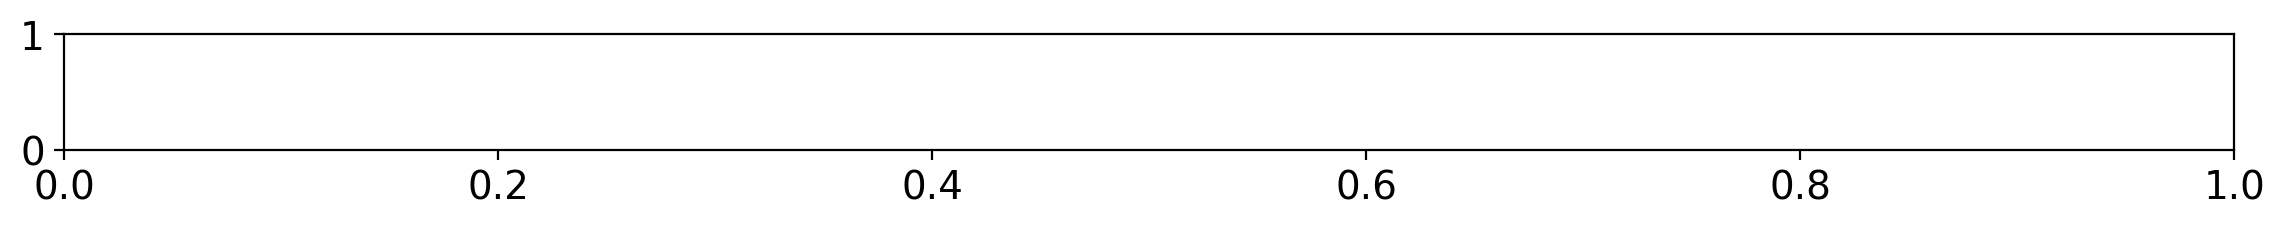

In [50]:
scaling1, analysis_setup, setup_specific_kwargs, orig_metric_map, color_map = get_bbh_subtask_scaling_metrics(task='overall',
                                                                                                              mmlu_subtasks=mmlu_subtasks)

task = 'overall'
weights_ranks = pd.DataFrame()

tiled_weights = plot_weight_analysis(
    merged_eval, 
    y_metrics=scaling1, 
    x_metrics_list=[PC_METRIC_NUM_2], 
    analysis_setup_kwargs=analysis_setup, 
    y_metric_specific_kwargs=setup_specific_kwargs, 
    #filter_model_family=EVAL_BASE_MODEL_FAMILIES, # not default
    norm_weights=False,
    remove_y_ticks=False,
    figsize=14,
    rotationx=90,
    cmap='coolwarm',
    v=2,
    task=task,
    get_tiled_weights=True
)

weights_ranks_list = [sorted(tiled_weights[0], reverse=True).index(x) for x in tiled_weights[0]]

for i, bench in enumerate(analysis_setup['imputation_metrics']):

    temp_dict = {
        'task': task,
        'benchmark': bench,
        'rank': weights_ranks_list[i]
    }
    temp_df = pd.DataFrame(temp_dict, index=[0])
    
    weights_ranks = pd.concat([weights_ranks, temp_df], axis=0, ignore_index=True)

Text(0.5, 1.0, 'Rank for BBH overall')

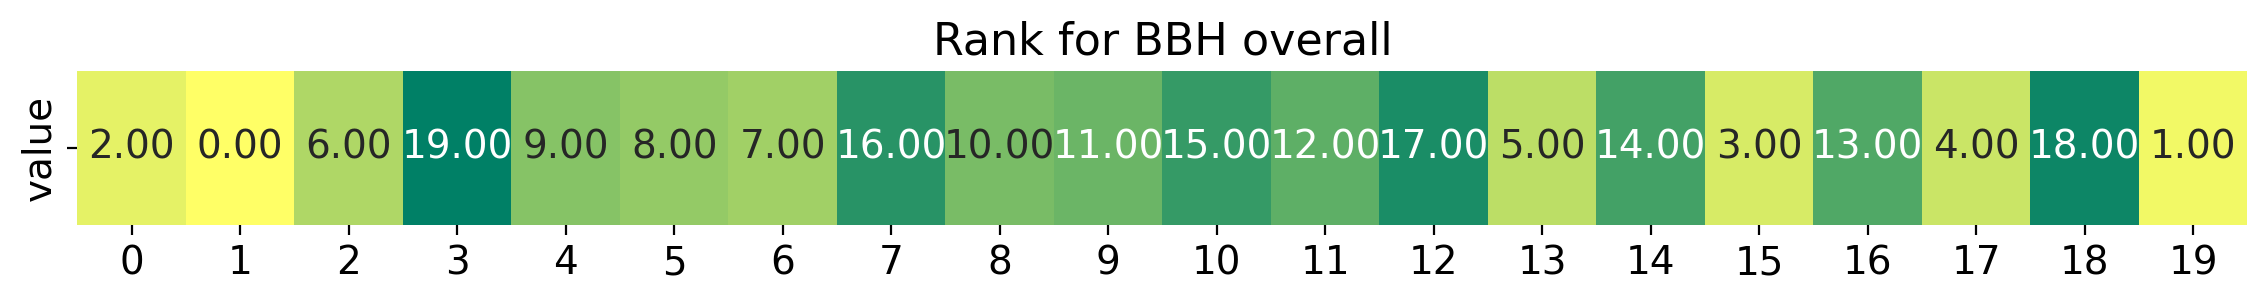

In [60]:
plt.figure(figsize=(14, 1))
sns.heatmap(weights_ranks['rank'].to_frame(name='value').T, cmap='summer_r', annot=True, fmt=".2f", cbar=False)
plt.title('Rank for BBH overall')